<h2><font color="#004D7F" size=6>TCGA Data Analysis Tool 1.0 </font></h2>
<h3><font color="#004D7F" size=4>- Jorge Iván Díaz Riaño PhD(c)  </font></h3>

<h1><font color="#004D7F" size=4>1. Loading and preprocessing data</font></h1>

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#Loading required packages and libraries
from IPython.display import display, HTML
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
from lifelines import KaplanMeierFitter
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import LinearSegmentedColormap
import warnings
import io
from ipywidgets import FileUpload, Button
from IPython.display import display
from sklearn.cluster import DBSCAN
from scipy.stats import expon

In [3]:
dataset=input("Enter path for csv file: ") #C:\\Users\\TTUSVM\\Documents\\GitHub\\TCGA-TTU\\TC3R\\Input\MAGE-TCGA-GBM_tpm_clinical.csv

Enter path for csv file: C:\\Users\\TTUSVM\\Documents\\GitHub\\TCGA-TTU\\TC3R\\Input\MAGE-TCGA-GBM_tpm_clinical.csv


In [4]:
# replace empty/invalid values with NaN
data= pd.read_csv(dataset, sep=',')
df = pd.DataFrame(data)
df.replace("\'--", np.nan, inplace=True)
df.replace('not reported', np.nan, inplace=True)
df.replace('Not Reported', np.nan, inplace=True)
df.set_index('sample', inplace=True)
df.head(4)

,TRO,NDN,NSMCE3,MAGEC2,MAGEB2,MAGED2,MAGEB4,MAGEA9,MAGEA10,TRIM28,...,treatment_arm,treatment_dose,treatment_dose_units,treatment_effect,treatment_effect_indicator,treatment_frequency,treatment_intent_type,treatment_or_therapy,treatment_outcome,treatment_type
sample,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047,25.8521,101.6848,13.5235,0.0482,0.0598,337.5721,0.0,0.0,0.0000,193.3670,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no,NaN,"Pharmaceutical Therapy, NOS"
TCGA-02-0055,14.5075,89.6786,26.6422,0.2301,0.1428,349.1256,0.0,0.0,0.0264,155.1753,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,NaN,"Radiation Therapy, NOS"
TCGA-02-2483,31.8243,145.3807,25.4736,1.0924,0.0000,358.0033,0.0,0.0,0.0000,425.5501,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,NaN,"Pharmaceutical Therapy, NOS"
TCGA-02-2485,39.4224,88.7591,32.5229,0.1313,0.0000,364.7759,0.0,0.0,0.0000,487.4934,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,NaN,"Pharmaceutical Therapy, NOS"


In [5]:
# Count of null data points
print(df.isnull().sum())

TRO                        0
NDN                        0
NSMCE3                     0
MAGEC2                     0
MAGEB2                     0
                        ... 
treatment_frequency      169
treatment_intent_type    169
treatment_or_therapy       9
treatment_outcome        169
treatment_type             1
Length: 202, dtype: int64


In [6]:
# drop columns with >0.8 NaN's
df = df.loc[:, df.isnull().mean() < .8]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 169 entries, TCGA-02-0047 to TCGA-76-4932
Data columns (total 68 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   TRO                          169 non-null    float64
 1   NDN                          169 non-null    float64
 2   NSMCE3                       169 non-null    float64
 3   MAGEC2                       169 non-null    float64
 4   MAGEB2                       169 non-null    float64
 5   MAGED2                       169 non-null    float64
 6   MAGEB4                       169 non-null    float64
 7   MAGEA9                       169 non-null    float64
 8   MAGEA10                      169 non-null    float64
 9   TRIM28                       169 non-null    float64
 10  MAGEA4                       169 non-null    float64
 11  MAGED4                       169 non-null    float64
 12  MAGEC1                       169 non-null    float64
 13  MAGEA

In [72]:
df['MAGEA6'].describe()

count    169.000000
mean       0.121617
std        0.280785
min        0.000000
25%        0.000000
50%        0.043800
75%        0.092600
max        2.581600
Name: MAGEA6, dtype: float64

<h1><font color="#004D7F" size=5>2. Visualization</font></h1>

<h1><font color="#004D7F" size=4>2.1 Correlation.</font></h1>

In [8]:
df_numeric = df.select_dtypes(include=['number'])
# Reorder columns based on the provided order
column_order = [
    "MAGEA1", "MAGEA2", "MAGEA2B", "MAGEA3", "MAGEA4", "MAGEA5", "MAGEA6", "MAGEA7P", "MAGEA8", "MAGEA9",
    "MAGEA9B", "MAGEA10", "MAGEA11", "MAGEA12", "MAGEB1", "MAGEB2", "MAGEB3", "MAGEB4", "MAGEB5", "MAGEB6",
    "MAGEB10", "MAGEB16", "MAGEB17", "MAGEB18", "MAGEC1", "MAGEC2", "MAGEC3", "MAGED1", "MAGED2", "TRO","MAGED4",
    "MAGED4B", "MAGEE1", "MAGEE2", "MAGEF1", "NSMCE3","MAGEH1", "MAGEL2", "CSAG1", "CSAG2", "CSAG3", "CSAG4", "TRIM28", "NDN"
]
df_numeric = df_numeric[column_order]

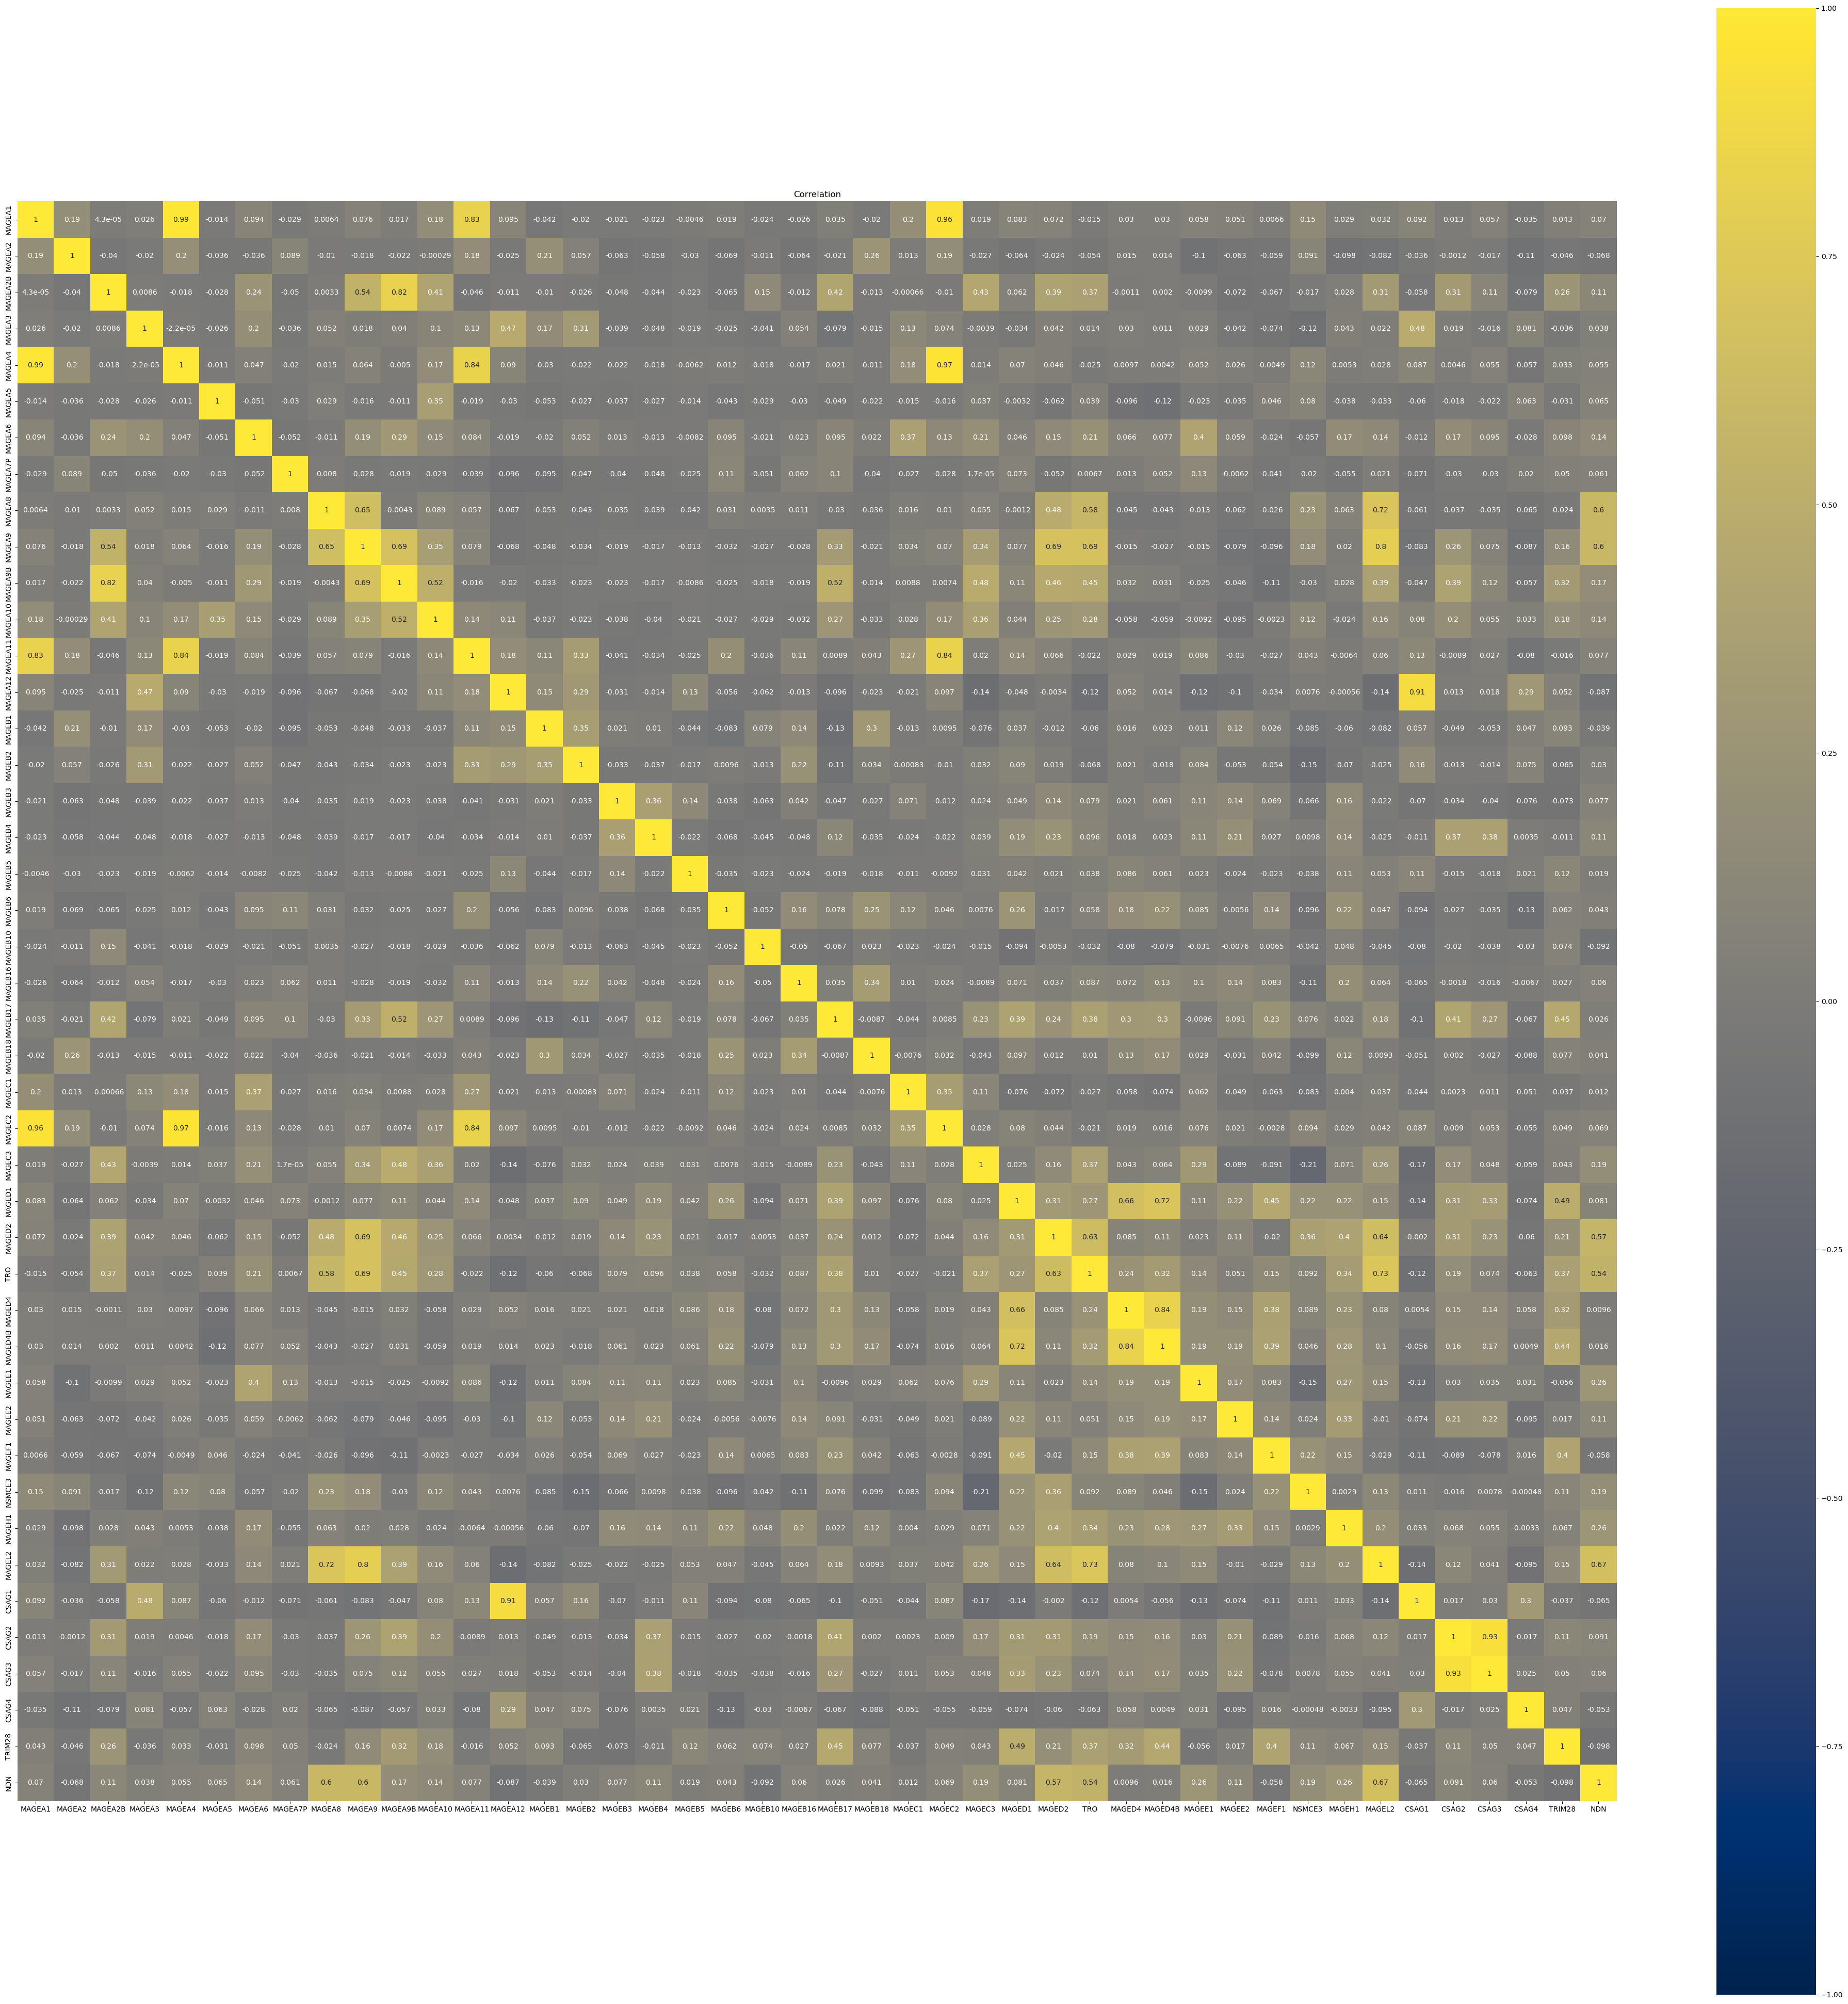

In [9]:
#Perform correlation (Pearson)
correlation = df_numeric.corr()
plt.figure(figsize = (50,50))
ax = sns.heatmap(correlation, vmax = 1, vmin = -1, square=True , annot=True, cmap = 'cividis') #Correlations from -1 to 1m change to vmin
correlation.to_csv('MAGEsPearsonCorrelation.csv')
plt.title('Correlation')
plt.show()

In [10]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    '''Get top absolute correlations'''
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

def get_bottom_abs_correlations(df, n=5):
    '''Get bottom absolute correlations'''
    au_corr = df.corr().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=True)
    return au_corr[0:n]

def get_all_abs_correlations(df):
    '''Get all absolute correlations'''
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr

In [11]:
numberCorr=int(input("Enter number of top/bottom correlations to be displayed: "))

Enter number of top/bottom correlations to be displayed: 10


In [12]:
print('Top of correlations')
print(get_top_abs_correlations(df_numeric, numberCorr).to_string())
print('\nBottom of correlations')
print(get_bottom_abs_correlations(df_numeric, numberCorr).to_string())

Top of correlations
MAGEA1   MAGEA4     0.985519
MAGEA4   MAGEC2     0.968048
MAGEA1   MAGEC2     0.959018
CSAG2    CSAG3      0.934754
MAGEA12  CSAG1      0.907400
MAGEA11  MAGEC2     0.841618
MAGEA4   MAGEA11    0.838770
MAGED4   MAGED4B    0.835517
MAGEA1   MAGEA11    0.829848
MAGEA2B  MAGEA9B    0.822867

Bottom of correlations
MAGEC3   NSMCE3   -0.207710
         CSAG1    -0.170379
MAGEB2   NSMCE3   -0.150764
MAGEE1   NSMCE3   -0.149634
MAGEA12  MAGEC3   -0.143343
         MAGEL2   -0.141139
MAGEL2   CSAG1    -0.138224
MAGED1   CSAG1    -0.137578
MAGEE1   CSAG1    -0.134939
MAGEB6   CSAG4    -0.129655


<h1><font color="#004D7F" size=4>2.2 Cutoffs generation</font></h1>

In [241]:
def find_optimal_cutoff(df, genes, value):
    # Select only the columns corresponding to the genes
    df_subset = df[genes]
    # Drop rows under positive/negative threshold
    df_subset = df_subset[(df_subset > value).any(axis=1)].dropna()
    print("Type of df_subset:", type(df_subset))
    print("Shape of df_subset:", df_subset.shape)
    # Fit an exponential distribution to the data
    params = expon.fit(df_subset.values.ravel())
    # Generate samples from the fitted distribution
    samples = expon.rvs(*params, size=1000)
    # Cluster the samples using DBSCAN
    dbscan = DBSCAN(eps=0.1, min_samples=5)
    labels = dbscan.fit_predict(samples.reshape(-1, 1))
    unique_labels, counts = np.unique(labels, return_counts=True)
    print("Finding optimal cutoff...")
    # Check if there are at least two clusters
    if len(unique_labels) >= 2:
        # Sort clusters by size
        sorted_clusters = sorted(zip(unique_labels, counts), key=lambda x: x[1], reverse=True)
        # Calculate the difference between the means of the two largest clusters
        cluster1_indices = np.where(labels == sorted_clusters[0][0])[0]
        cluster2_indices = np.where(labels == sorted_clusters[1][0])[0]
        cluster1_mean = np.mean(samples[cluster1_indices])
        cluster2_mean = np.mean(samples[cluster2_indices])
        diff = np.abs(cluster1_mean - cluster2_mean)
        # Update optimal cutoff and optimal difference if difference is maximized
        optimal_cutoff = np.min([cluster1_mean, cluster2_mean])
        optimal_diff = diff
        optimal_labels = labels
        min_input = np.min(df_subset)
        max_input = np.max(df_subset)
        print("Min input:", min_input)
        print("Max input:", max_input)
        print("TPM Positive/Negative threshold:", value)
        print("log10(TPM+1) Positive/Negative threshold:", np.log10(value + 1))
    else:
        print("No optimal cutoff found greater than PosNegCriteria. Returning default values.")
        return -1, None, None, None
  # Sort dataframe based on the selected gene in descending order
    sorted_df = df.sort_values(by=genes[0], ascending=False)
    plt.figure(figsize=(20, 6))  # Adjust the width and height as needed
    # Plot log10(value+1) for X-axis
    plt.plot(range(len(sorted_df[genes])), np.log10(sorted_df[genes]+ 1), marker='o', linestyle='', label='Expression values')
    # Plot lines at the points where the curve intersects the X-axis for PosNegCriteria and cutoff_value
    posneg_criteria_value = np.log10(value+1)
    plt.axhline(y=posneg_criteria_value, color='g', linestyle='--', label='PosNegCriteria')
    plt.axhline(y=np.log10(optimal_cutoff+1), color='b', linestyle='--', label='Optimal Cutoff')
    plt.title(f"Expression classification according with {genes[0]}")
    plt.xlabel('Samples ID')
    plt.ylabel('Log10(TPM+1)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return optimal_cutoff, optimal_diff, optimal_labels, None

In [244]:
GeneName=input("Enter a Gene-name to be evaluated: ")
PosNegCriteria=float(input("Enter a cut-off value to separate positive and negative tumors: "))

Enter a Gene-name to be evaluated: MAGEA3
Enter a cut-off value to separate positive and negative tumors: 0


count    169.000000
mean       0.165129
std        0.640966
min        0.000000
25%        0.000000
50%        0.040300
75%        0.095800
max        6.552200
Name: MAGEA3, dtype: float64
Type of df_subset: <class 'pandas.core.frame.DataFrame'>
Shape of df_subset: (104, 1)
Finding optimal cutoff...
Min input: 0.0271
Max input: 6.5522
TPM Positive/Negative threshold: 0.0
log10(TPM+1) Positive/Negative threshold: 0.0


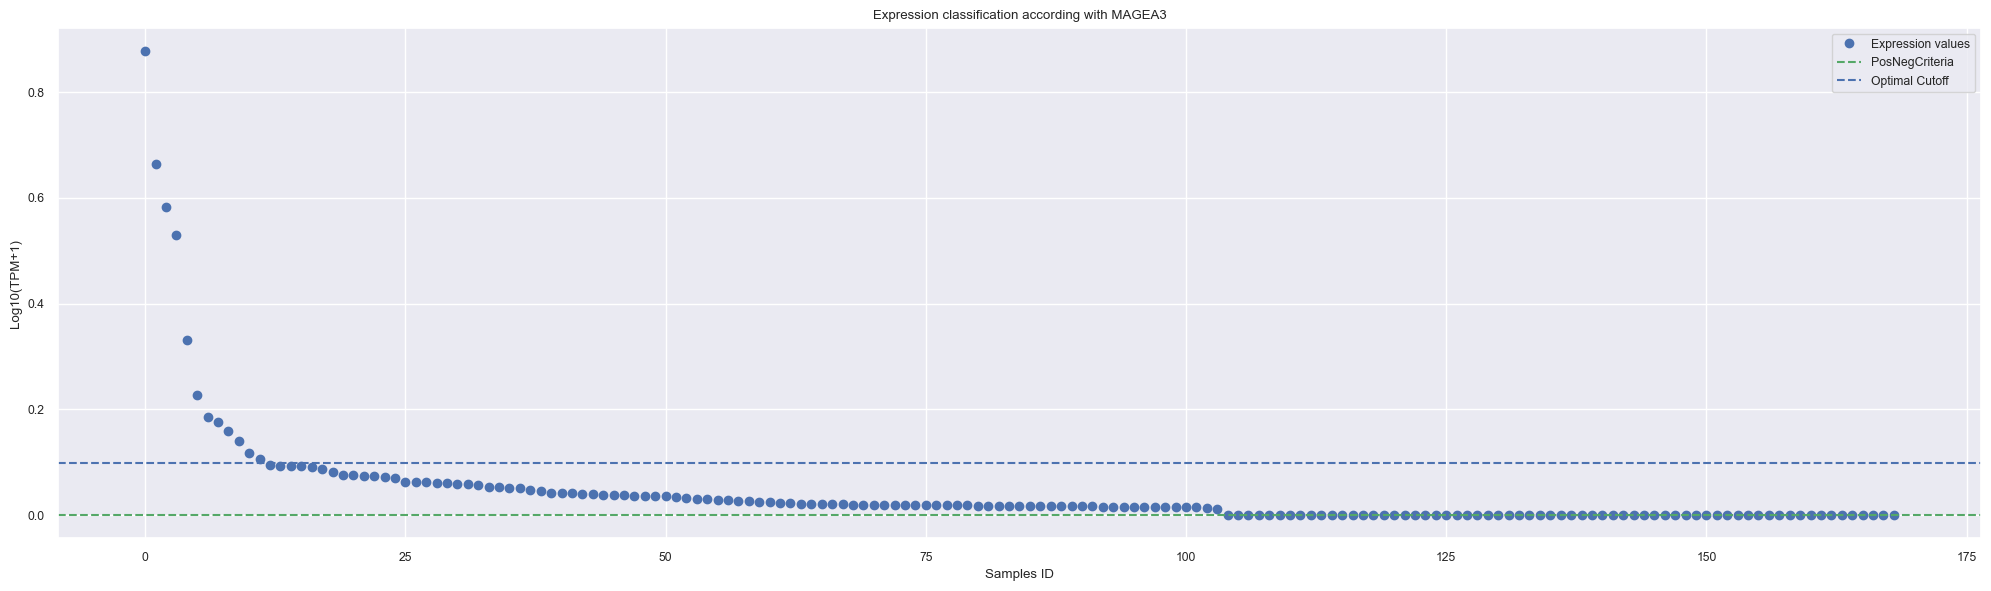

Optimal cutoff value: 0.25411655559486285 TPMs,  Normalized:  0.09833790100774818


In [245]:
print(df[GeneName].describe())
cutoff_value, optimal_diff, optimal_labels, optimal_centroids = find_optimal_cutoff(df_numeric, [GeneName], PosNegCriteria)
if cutoff_value != -1:
    print("Optimal cutoff value:", cutoff_value, "TPMs, ", "Normalized: ", np.log10(cutoff_value + 1))

<h1><font color="#004D7F" size=4>2.3 Distribution of TPMs.</font></h1>

In [13]:
# Set colors
colors_pastel = sns.color_palette("Set2")

def plot_gene_histograms_type1(gene_list):
    plt.figure(figsize=(15, 10))
    for gene in gene_list:
        plt.subplot(5, 6, gene_list.index(gene) + 1)
        plt.hist(np.log10(df_numeric[gene] + 1), bins=20, color=colors_pastel[2], edgecolor='black')  # Using color from palette
        plt.title(gene)
        plt.xlabel('Log10(TPM+1)')
        plt.ylabel('Frequency')
        plt.grid(True)
    plt.tight_layout()
    plt.show()
    
def plot_gene_histograms_type2(gene_list):
    plt.figure(figsize=(15, 10))
    for gene in gene_list:
        plt.subplot(5, 6, gene_list.index(gene) + 1)
        plt.hist(np.log10(df_numeric[gene] + 1), bins=20, color=colors_pastel[5], edgecolor='black')  # Using color from palette
        plt.title(gene)
        plt.xlabel('Log10(TPM+1)')
        plt.ylabel('Frequency')
        plt.grid(True)
    plt.tight_layout()
    plt.show()

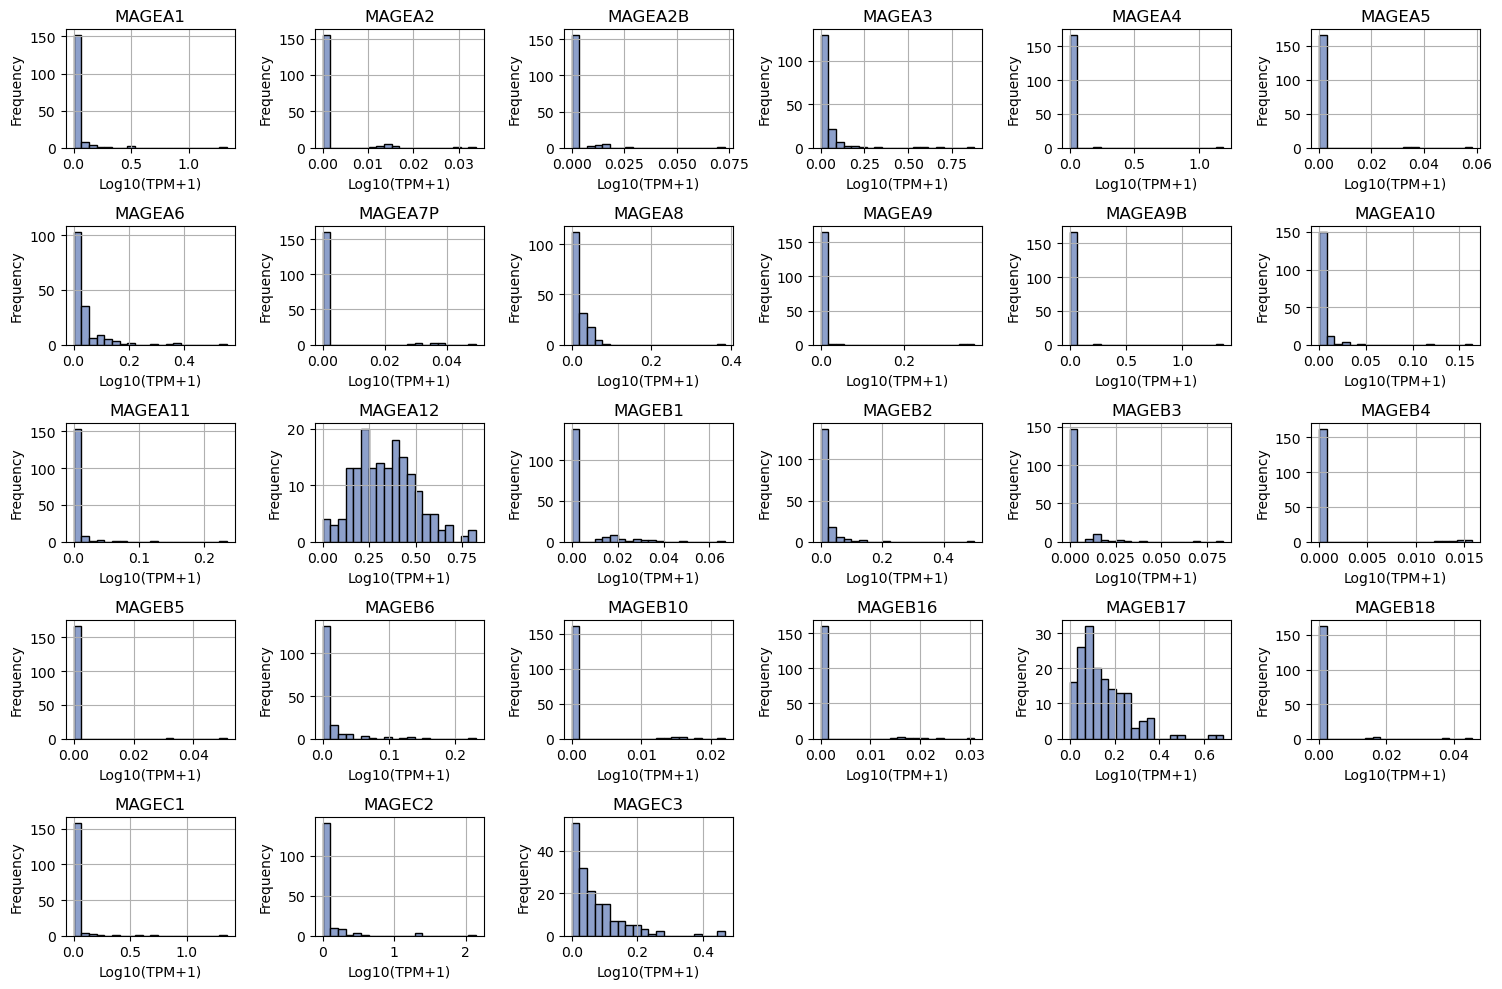

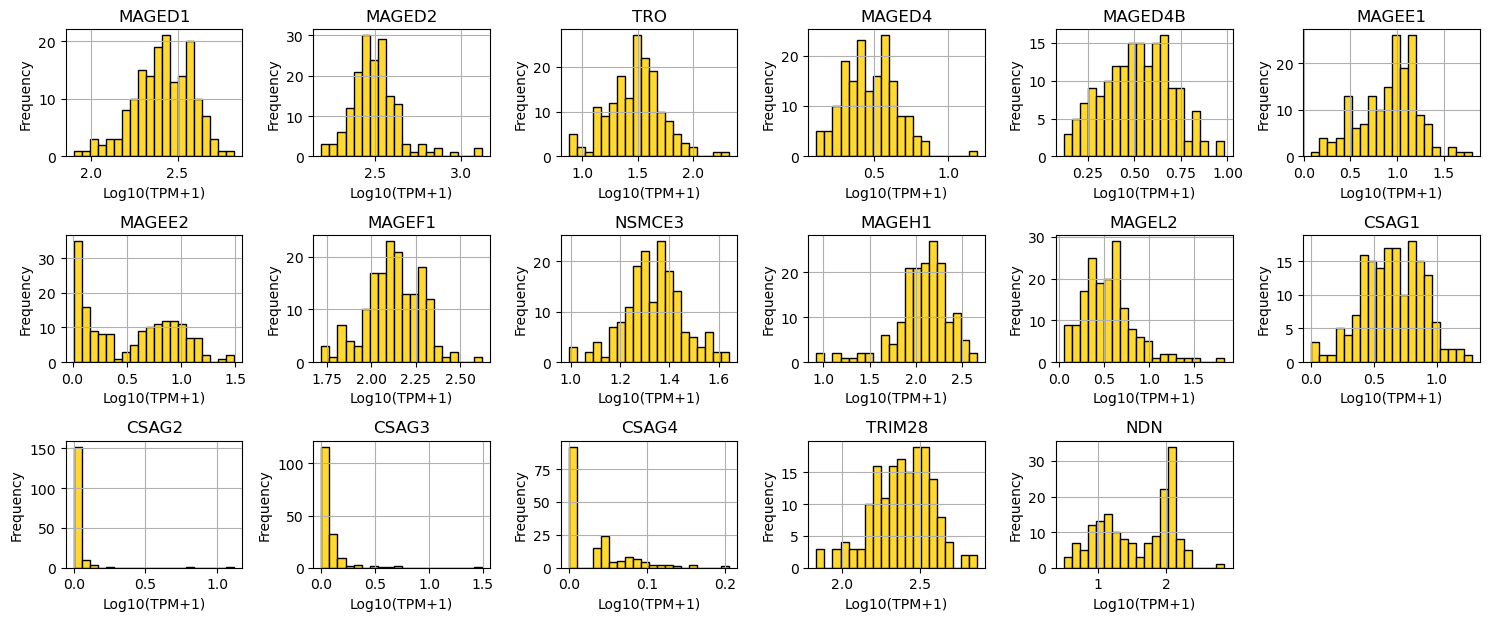

In [15]:
Type1 = ["MAGEA1", "MAGEA2", "MAGEA2B", "MAGEA3", "MAGEA4", "MAGEA5", "MAGEA6", "MAGEA7P", "MAGEA8", "MAGEA9","MAGEA9B", "MAGEA10", "MAGEA11", "MAGEA12", "MAGEB1", "MAGEB2", "MAGEB3", "MAGEB4", "MAGEB5", "MAGEB6",
    "MAGEB10", "MAGEB16", "MAGEB17", "MAGEB18", "MAGEC1", "MAGEC2", "MAGEC3"]
Type2 = [ "MAGED1", "MAGED2", "TRO","MAGED4", "MAGED4B", "MAGEE1", "MAGEE2", "MAGEF1", "NSMCE3","MAGEH1", "MAGEL2", "CSAG1", "CSAG2", "CSAG3", "CSAG4", "TRIM28", "NDN"]
plot_gene_histograms_type1(Type1)
plot_gene_histograms_type2(Type2)

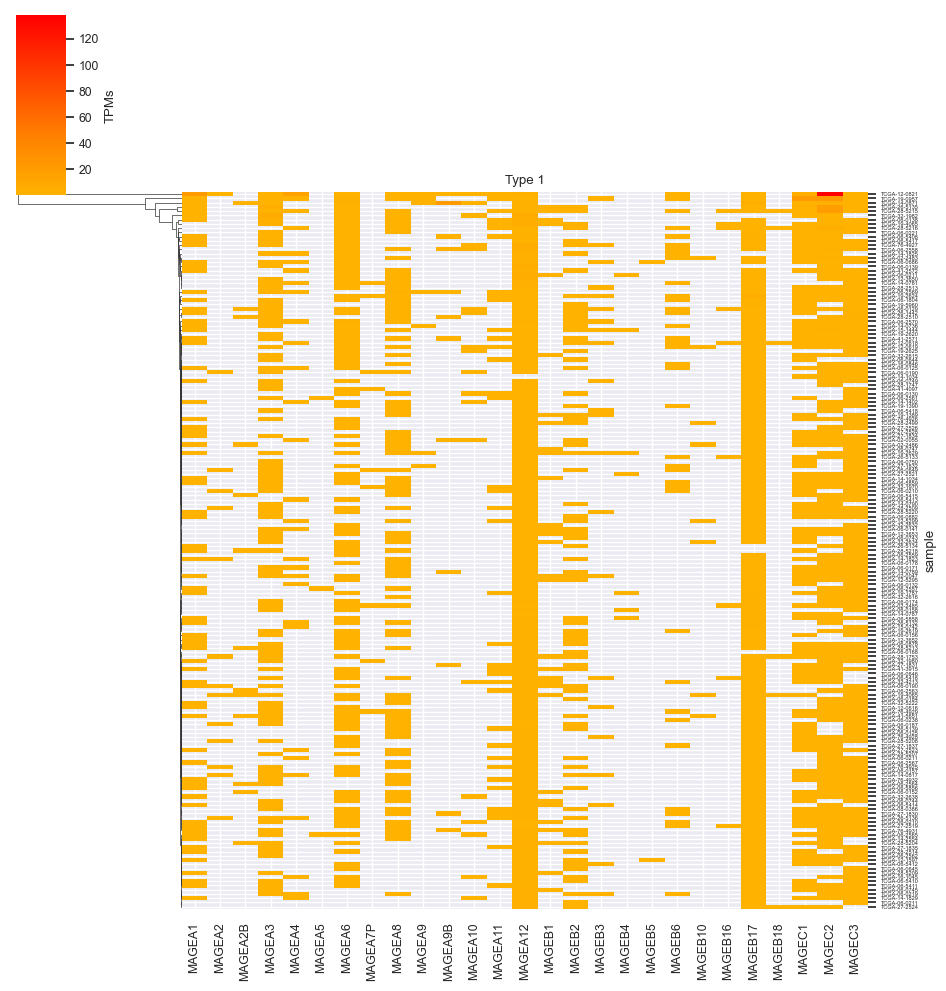

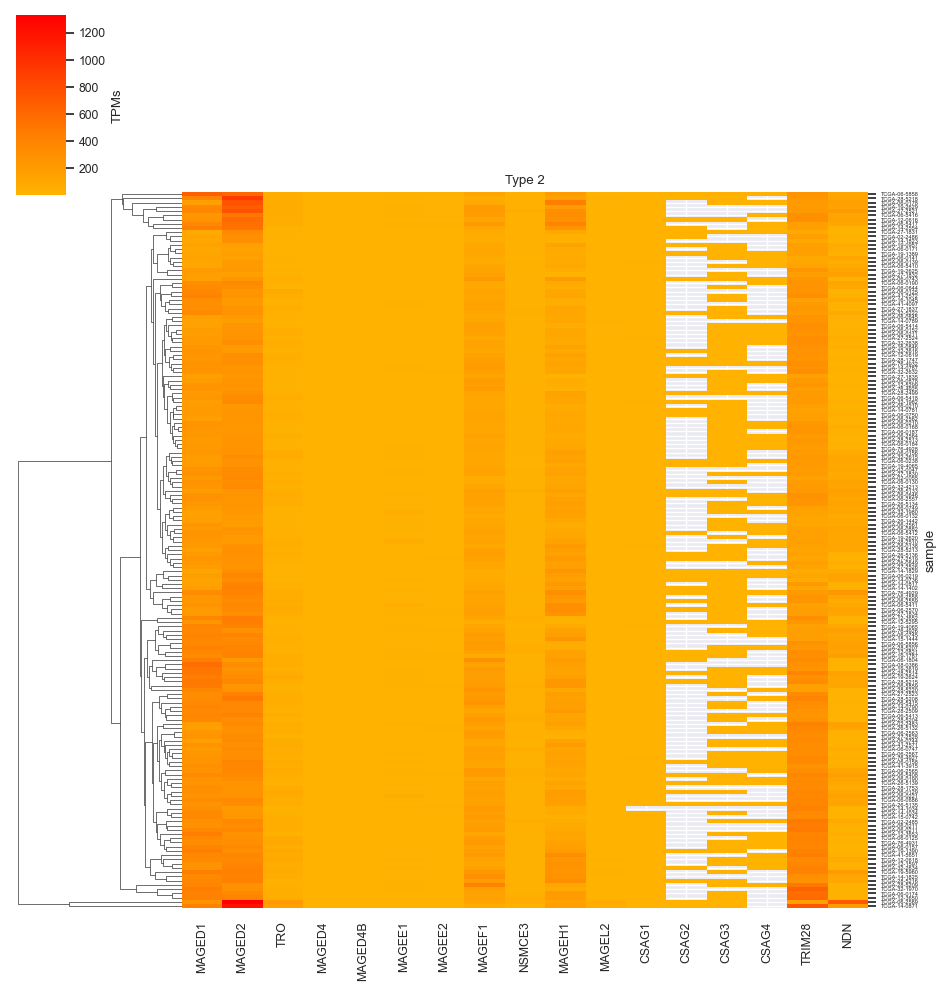

In [242]:
# Define the function to create custom colormap
def create_custom_colormap():
    # Define the colors
    colors = [(1, 1, 1), (1, 0.9, 0), (1, 0.5, 0), (1, 0, 0)]  # white to orange to red
    # Define the breakpoints for the color transition
    breakpoints = np.linspace(0, 1, len(colors))
    # Create a segmented colormap
    cmap_name = 'custom_red'
    cmap = LinearSegmentedColormap.from_list(cmap_name, list(zip(breakpoints, colors)))
    # Set masked values to be transparent
    cmap.set_bad(color='gray', alpha=0)
    return cmap

# Load your data and define Type1 and Type2
# Assuming df_numeric, Type1, and Type2 are defined

# Create custom colormap
custom_cmap = create_custom_colormap()

# Use the custom colormap in the heatmap for type 1
type1_df = df_numeric[Type1]
sns.set(font_scale=0.8)
g = sns.clustermap(type1_df, cmap=custom_cmap, center=0, cbar_kws={'label': 'TPMs'}, row_cluster=True, col_cluster=False, xticklabels=True, yticklabels=True, mask=(type1_df==0))
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize=3)
g.ax_heatmap.set_title('Type 1')
g.ax_heatmap.tick_params(axis='y', which='major', labelsize=4)

# Use the custom colormap in the heatmap for type 2
type2_df = df_numeric[Type2]
sns.set(font_scale=0.8)
f = sns.clustermap(type2_df, cmap=custom_cmap, center=0, cbar_kws={'label': 'TPMs'}, row_cluster=True, col_cluster=False, xticklabels=True, yticklabels=True, mask=(type2_df==0))
f.ax_heatmap.set_yticklabels(f.ax_heatmap.get_ymajorticklabels(), fontsize=3)
f.ax_heatmap.set_title('Type 2')
f.ax_heatmap.tick_params(axis='y', which='major', labelsize=4)

plt.show()

0.0
0.25411655559486285


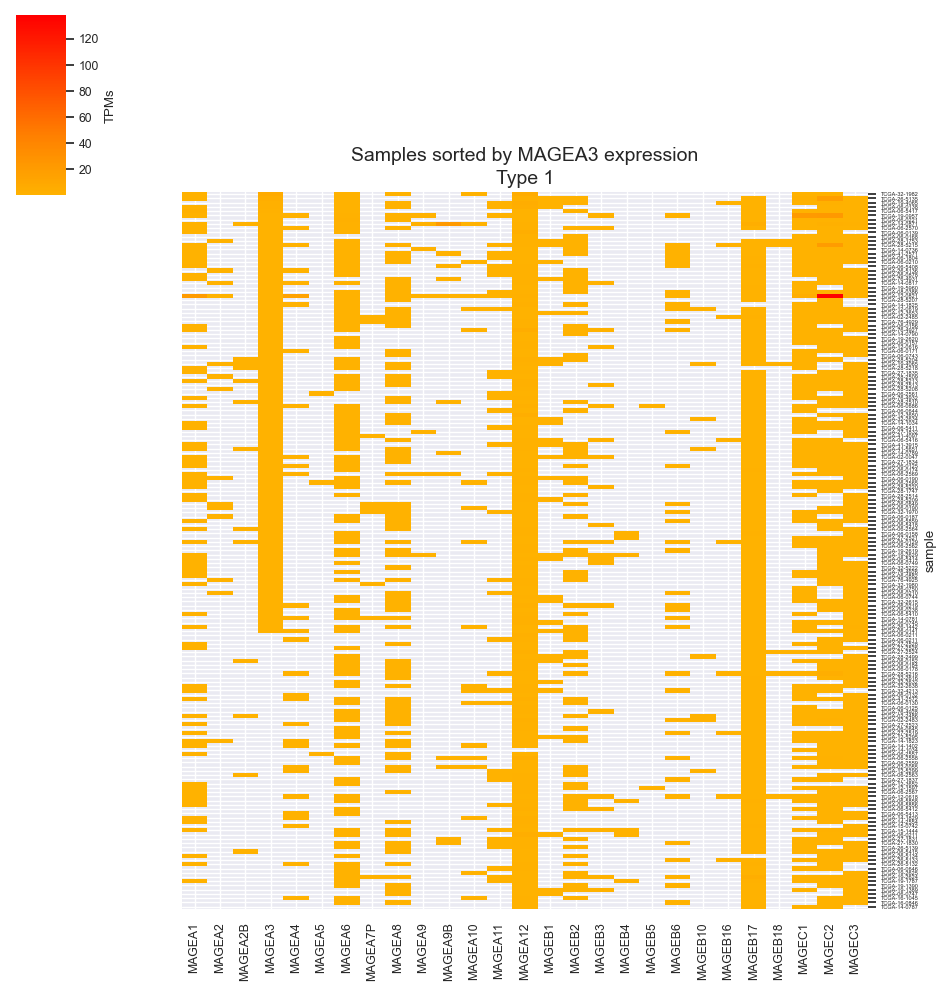

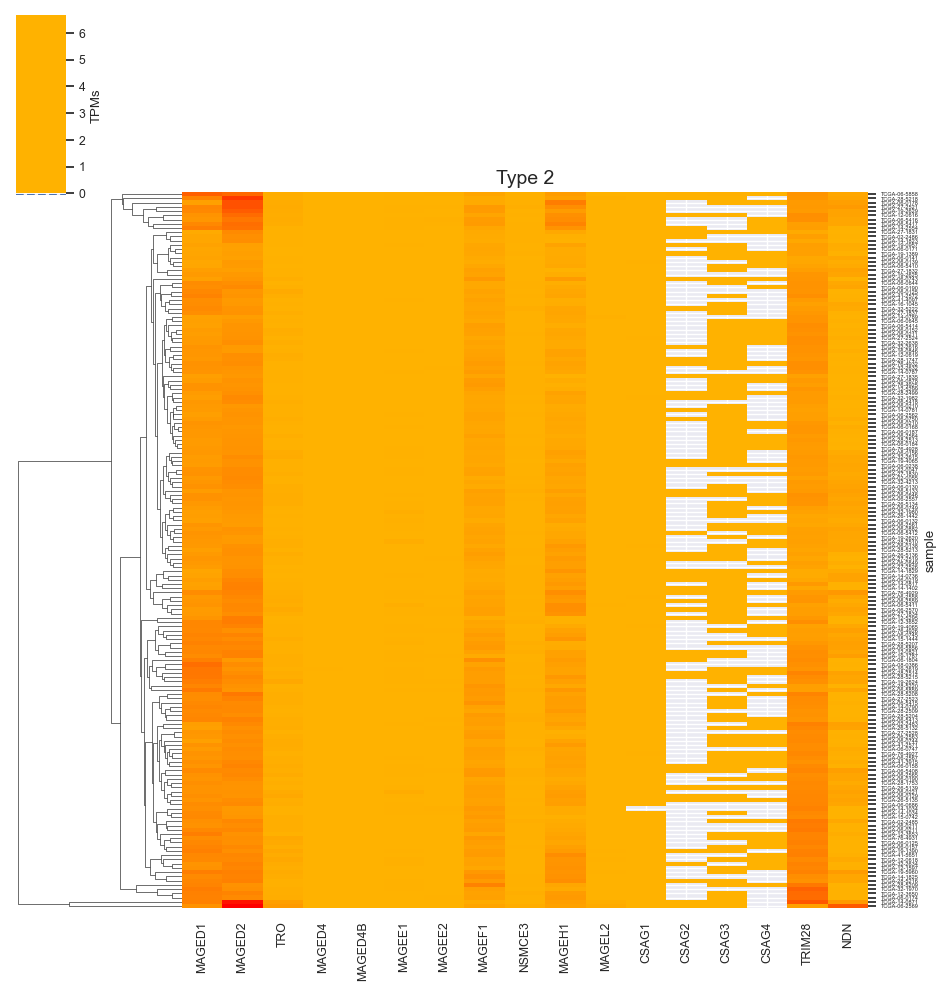

In [265]:
def create_custom_colormap():
    # Define the colors
    colors = [(1, 1, 1), (1, 0.9, 0), (1, 0.5, 0), (1, 0, 0)]  # white to orange to red
    # Define the breakpoints for the color transition
    breakpoints = np.linspace(0, 1, len(colors))
    # Create a segmented colormap
    cmap_name = 'custom_red'
    cmap = LinearSegmentedColormap.from_list(cmap_name, list(zip(breakpoints, colors)))
    # Set masked values to be transparent
    cmap.set_bad(color='gray', alpha=0)
    return cmap

print(PosNegCriteria)
print(cutoff_value)
# Sort the DataFrame based on GeneName column
sorted_df_numeric = df_numeric.sort_values(by=GeneName, ascending=False)

# Create custom colormap
custom_cmap = create_custom_colormap()

# Use the custom colormap in the heatmap for type 1
type1_df = sorted_df_numeric[Type1]
sns.set(font_scale=0.8)
g = sns.clustermap(type1_df, cmap=custom_cmap, center=0, cbar_kws={'label': 'TPMs'}, row_cluster=False, col_cluster=False, xticklabels=True, yticklabels=True, mask=(type1_df==0))
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize=3)
g.ax_heatmap.set_title('Type 1', fontsize=14)
g.ax_heatmap.tick_params(axis='y', which='major', labelsize=4)

# Use the custom colormap in the heatmap for type 2
type2_df = sorted_df_numeric[Type2]
sns.set(font_scale=0.8)
f = sns.clustermap(type2_df, cmap=custom_cmap, center=0, cbar_kws={'label': 'TPMs'}, row_cluster=True, col_cluster=False, xticklabels=True, yticklabels=True, mask=(type2_df==0))
f.ax_heatmap.set_yticklabels(f.ax_heatmap.get_ymajorticklabels(), fontsize=3)
f.ax_heatmap.set_title('Type 2', fontsize=14)
f.ax_heatmap.tick_params(axis='y', which='major', labelsize=4)

# Add text annotation indicating the ordering using GeneName
g.ax_heatmap.text(0.5, 1.05, 'Samples sorted by ' + GeneName + ' expression', horizontalalignment='center', verticalalignment='center', transform=g.ax_heatmap.transAxes, fontsize=14)
# Add horizontal line to indicate the minimum value over PosNegCriteria
#min_value_over_criteria = np.min(sorted_df_numeric[GeneName][sorted_df_numeric[GeneName] > PosNegCriteria])
#print(min_value_over_criteria)
# Calculate a reasonable y-value for the horizontal line
y_value = min_value_over_criteria - 0.1  # Adjust this value as needed

# Set y-axis limits explicitly
plt.ylim(bottom=min_value_over_criteria - 0.1, top=max(sorted_df_numeric[GeneName]) + 0.1)

# Add horizontal line to indicate the minimum value over PosNegCriteria
plt.axhline(y=y_value, color='b', linestyle='--')

plt.show()
plt.show()

<h1><font color="#004D7F" size=4>2.4 Composition of Positive and Negative Tumors by MAGEs.</font></h1>

In [ ]:
no_zero = df_numeric.astype(bool).sum(axis=0)
zero = df_numeric.shape[0] - no_zero
# New df to order output
output_df = pd.DataFrame({'Positive_counts': no_zero, 'Negative_counts': zero})
output_df['Total_counts'] = output_df['Positive_counts'] + output_df['Negative_counts']
# Calculate percentages
percentage_df = output_df[['Positive_counts', 'Negative_counts']].div(output_df['Total_counts'], axis=0) * 100
# Concatenate percentages with original DataFrame
output_df = pd.concat([output_df, percentage_df.add_suffix('_percentage')], axis=1)
# Sort DataFrame by column names (alphabetical order)
output_df = output_df.sort_index()
finalTable= output_df[['Positive_counts','Positive_counts_percentage','Negative_counts','Negative_counts_percentage']]
finalTable=finalTable.round(1)
finalTable=finalTable.loc[column_order]
finalTable.to_csv('MAGEsComposition.csv')
finalTable.head(3)

In [ ]:
# Normalization
total_counts = no_zero + zero
positive_normalized = no_zero / total_counts
positive_normalized= positive_normalized[column_order]
negative_normalized = zero / total_counts
negative_normalized= negative_normalized[column_order]
# Set colors
colors_pastel = sns.color_palette("Set2")
# Stacked barplot
plt.figure(figsize=(10, 6))
positive_normalized.plot(kind='bar', color=colors_pastel[2], width=0.4, position=1, label='Positive')
negative_normalized.plot(kind='bar', color=colors_pastel[5], width=0.4, position=1, bottom=positive_normalized, label='Negative')
plt.title('Composition of Positive and Negative Tumors for MAGE')
plt.ylabel('Ratio of positive and negative samples')
plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.text(1.09, 0.8, 'n=169', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.tight_layout()
plt.show()

<h1><font color="#004D7F" size=4>2.5. Overview clinical data.</font></h1>

<h3>Definitions:</h3>

**ethnicity:** An individual's self-described social and cultural grouping, specifically whether an individual describes themselves as Hispanic or Latino. The provided values are based on the categories defined by the U.S. Office of Management and Business and used by the U.S. Census Bureau.<br>
**gender:** Text designations that identify gender. Gender is described as the assemblage of properties that distinguish people on the basis of their societal roles. [Explanatory Comment 1: Identification of gender is based upon self-report and may come from a form, questionnaire, interview, etc.]<br>
**race:** An arbitrary classification of a taxonomic group that is a division of a species. It usually arises as a consequence of geographical isolation within a species and is characterized by shared heredity, physical attributes and behavior, and in the case of humans, by common history, nationality, or geographic distribution. The provided values are based on the categories defined by the U.S. Office of Management and Business and used by the U.S. Census Bureau.<br>
**vital_status:** The survival state of the person registered on the protocol.<br>
**treatment_or_therapy:** A yes/no/unknown/not applicable indicator related to the administration of therapeutic agents received.<br>
**treatment_type:** Text term that describes the kind of treatment administered.<br>

[TCGA- Data Dictionary](https://docs.gdc.cancer.gov/Data_Dictionary/viewer/#?view=table-entity-list&anchor=clinical)

In [ ]:
df_filled = df.copy()
# Define columns for bar plots
columns_bar = ['ethnicity', 'gender', 'race', 'vital_status', 'treatment_or_therapy', 'treatment_type']
# Calculate the number of rows and columns needed for subplots
num_cols_bar = 3  # Number of columns in the subplot grid for bar plots
num_rows_bar = (len(columns_bar) + num_cols_bar - 1) // num_cols_bar  # Calculate the number of rows needed
# Create a figure and set its size
plt.figure(figsize=(15, 20))
# Set a title for the entire figure
plt.suptitle('Overview for Relevant Clinical Data', fontsize=16)
# Loop through each column and create a subplot
colors_pastel = sns.color_palette("Set2")
for i, column in enumerate(columns_bar, 1):
    plt.subplot(num_rows_bar, num_cols_bar, i)
    # Plot bar plot for the current column
    counts = df_filled[column].value_counts()
    counts.plot(kind='bar', color=colors_pastel[2])
    # Annotate each bar with the count value if possible
    for j, count in enumerate(counts):
        plt.text(j, count + 0.5, str(count), ha='center', va='bottom')
    # Remove x-axis label
    plt.xlabel('')
    # Set y-axis label
    plt.ylabel('Count')
    # Set title for the subplot
    plt.title(column)
# Adjust the layout to prevent overlapping of subplots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# Show the plot
plt.show()

<h3>Definitions:</h3>

**age_at_index:** The patient's age (in years) on the reference or anchor date used during date obfuscation.<br>
**days_to_birth:** Number of days between the date used for index and the date from a person's date of birth represented as a calculated negative number of days.<br>
**days_to_death:** Number of days between the date used for index and the date from a person's date of death represented as a calculated number of days.<br>
**days_to_last_follow_up:** Time interval from the date of last follow up to the date of initial pathologic diagnosis, represented as a calculated number of days.<br>
**year_of_birth:** Numeric value to represent the calendar year in which an individual was born.<br>
**year_of_death:** Numeric value to represent the year of the death of an individual.<br>
**age_at_diagnosis:** Age at the time of diagnosis expressed in number of days since birth.<br>
**year_of_diagnosis:** Numeric value to represent the year of an individual's initial pathologic diagnosis of cancer.<br>

[TCGA- Data Dictionary](https://docs.gdc.cancer.gov/Data_Dictionary/viewer/#?view=table-entity-list&anchor=clinical)

In [ ]:
# Define columns for boxplots (removed 'age_at_index')
columns_box = ['days_to_birth', 'days_to_death', 'days_to_last_follow_up', 'year_of_birth', 'year_of_death',
               'age_at_diagnosis', 'year_of_diagnosis']
# Remove NaN values from specified columns
df_filled = df_filled.dropna(subset=columns_box)
# Calculate the number of rows and columns needed for subplots
num_cols_box = 4  # Number of columns in the subplot grid for bar plots
num_rows_box = (len(columns_box) + num_cols_box - 1) // num_cols_box  # Calculate the number of rows needed
# Create a figure and set its size
plt.figure(figsize=(15, 20))
# Set a title for the entire figure
plt.suptitle('Overview for Relevant Clinical Data', fontsize=16)
# Loop through each column and create a subplot
for i, column in enumerate(columns_box, 1):
    plt.subplot(num_rows_box, num_cols_box, i)
    # Plot box plot for the current column without 0 values
    df_column = pd.to_numeric(df_filled[column], errors='coerce')
    df_column = df_column[df_column != 0]
    df_column.plot(kind='box')
    # Set subplot title
    plt.title(column)
# Adjust the layout to prevent overlapping of subplots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# Show the plot
plt.show()

In [ ]:
# Define columns for histograms (Removed 'age_at_index')
columns_hist = ['days_to_birth', 'days_to_death', 'days_to_last_follow_up', 'year_of_birth', 'year_of_death',
               'age_at_diagnosis', 'year_of_diagnosis']
# Remove NaN values from specified columns
df_filled = df_filled.dropna(subset=columns_hist)
# Calculate the number of rows and columns needed for subplots
num_cols_hist = 4  # Number of columns in the subplot grid for histograms
num_rows_hist = (len(columns_hist) + num_cols_hist - 1) // num_cols_hist  # Calculate the number of rows needed
# Create a figure and set its size
plt.figure(figsize=(15, 20))
# Set a title for the entire figure
plt.suptitle('Overview for Relevant Clinical Data', fontsize=16)
# Loop through each column and create a subplot
for i, column in enumerate(columns_hist, 1):
    plt.subplot(num_rows_hist, num_cols_hist, i)
    # Plot histogram for the current column without 0 values
    df_column = pd.to_numeric(df_filled[column], errors='coerce')
    df_column = df_column[df_column != 0]
    df_column.hist()
    # Set subplot title
    plt.title(column)
# Adjust the layout to prevent overlapping of subplots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# Show the plot
plt.show()

In [ ]:
# Assuming you have a DataFrame named 'df' containing gene expression data and a column named 'gender'
genes = [
    "MAGEA1", "MAGEA2", "MAGEA2B", "MAGEA3", "MAGEA4", "MAGEA5", "MAGEA6", "MAGEA7P", "MAGEA8", "MAGEA9",
    "MAGEA9B", "MAGEA10", "MAGEA11", "MAGEA12", "MAGEB1", "MAGEB2", "MAGEB3", "MAGEB4", "MAGEB5", "MAGEB6",
    "MAGEB10", "MAGEB16", "MAGEB17", "MAGEB18", "MAGEC1", "MAGEC2", "MAGEC3", "MAGED1", "MAGED2", "TRO","MAGED4",
    "MAGED4B", "MAGEE1", "MAGEE2", "MAGEF1", "NSMCE3","MAGEH1", "MAGEL2", "CSAG1", "CSAG2", "CSAG3", "CSAG4", "TRIM28", "NDN"
]

# Extract unique categories from the 'gender' column
genders = df['gender'].unique()

# Initialize a dictionary to store counts
counts_dict = {'Gene': [], 'Gender': [], 'Positive': [], 'Negative': []}

# Iterate over each MAGE gene and sex
for gene in genes:
    for gender in genders:
        # Filter dataframe for the current MAGE gene and sex
        filtered_df = df[(df[gene] > 0) & (df['gender'] == gender)]   
        
        # Count positive and negative cases
        positive_count = filtered_df.shape[0]
        negative_count = df[(df[gene] == 0) & (df['gender'] == gender)].shape[0]
        
        # Append counts to the dictionary
        counts_dict['Gene'].append(gene)
        counts_dict['Gender'].append(gender)
        counts_dict['Positive'].append(positive_count)
        counts_dict['Negative'].append(negative_count)

# Create a new dataframe from the counts dictionary
counts_df = pd.DataFrame(counts_dict)

# Display the resulting dataframe
counts_df['Total'] = counts_df['Positive']+counts_df['Negative']
counts_df['PositiveRatio'] = counts_df['Positive'] / counts_df['Total']
counts_df['NegativeRatio'] = counts_df['Negative'] / counts_df['Total']
counts_df= counts_df.dropna(subset=['Gender'])
counts_df = subset['Gene','Gender','PositiveRatio', 'NegativeRatio']
print(counts_df)

In [ ]:
# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=counts_df, x='Gene', y='Positive', hue='Gender', palette='pastel',errorbar=None)
plt.title('Positive Counts by Gene and Gender')
plt.ylabel('Count')
plt.xlabel('Gene')
plt.legend(title='Gender')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=counts_df, x='Gene', y='Negative', hue='Gender', palette='pastel',errorbar=None)
plt.title('Negative Counts by Gene and Gender')
plt.ylabel('Count')
plt.xlabel('Gene')
plt.legend(title='Gender')
plt.show()

In [ ]:
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Plot the first grouped bar plot
sns.barplot(ax=axes[0], x='Gene', y='Positive', hue='Gender', data=counts_df, palette='Set2', errorbar=None)
axes[0].set_title('Positive Cases by Gene and Gender')
axes[0].set_xlabel('')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=90)
axes[0].legend(title='Gender')

# Plot the second grouped bar plot
sns.barplot(ax=axes[1], x='Gene', y='Negative', hue='Gender', data=counts_df, palette='Set1', errorbar=None)
axes[1].set_title('Negative Cases by Gene and Gender')
axes[1].set_xlabel('')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=90)
axes[1].legend(title='Gender')

plt.tight_layout()
plt.show()

<h1><font color="#004D7F" size=4>2.6 Genes expression vs time after diagnosis.  </font></h1>

In [ ]:
# Convert 'days_to_death' and 'days_to_last_follow_up' to numeric
df['days_to_death'] = pd.to_numeric(df['days_to_death'], errors='coerce')
df['days_to_last_follow_up'] = pd.to_numeric(df['days_to_last_follow_up'], errors='coerce')

# Create new column 'years_after_diagnosis'
df['years_after_diagnosis'] = df.apply(lambda row: row['days_to_death'] / 365 if row['vital_status'] == 'Dead' else row['days_to_last_follow_up'] / 365, axis=1)

# Displaying the first few rows of the dataframe to verify the changes
df.head(2)

In [ ]:
# Reset index to avoid duplicate labels error
df_reset = df.reset_index()
# Normalize values by taking log10(values+1)
for gene in genes:
    df_reset[gene] = np.log10(df_reset[gene] + 1)

# Plotting
num_cols = 4
num_rows = (len(genes) + num_cols - 1) // num_cols  # Calculate the number of rows needed

plt.figure(figsize=(15, 4 * num_rows))  # Adjust figure size based on the number of rows
sns.set_style("whitegrid")

for i, gene in enumerate(genes, start=1):
    plt.subplot(num_rows, num_cols, i)
    sns.scatterplot(y='years_after_diagnosis', x=gene, hue='vital_status', data=df_reset, alpha=0.7)  # Transposed x and y
    plt.title(f'{gene} Survival scatter plot')
    plt.xlabel('Log10(TPM+1)')  # Adjusted label
    plt.ylabel('Years after Diagnosis')  # Adjusted label
    plt.legend(title='Vital Status')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

<h1><font color="#004D7F" size=5>3. Complex Data exploration</font></h1>

<h1><font color="#004D7F" size=4>3.1. PCA Tumors against categorical (clinical) variables.</font></h1>

In [ ]:
# Load dataset
column_order = ["MAGEA1", "MAGEA2", "MAGEA2B", "MAGEA3", "MAGEA4", "MAGEA5", "MAGEA6", "MAGEA7P", "MAGEA8", "MAGEA9",
    "MAGEA9B", "MAGEA10", "MAGEA11", "MAGEA12", "MAGEB1", "MAGEB2", "MAGEB3", "MAGEB4", "MAGEB5", "MAGEB6",
    "MAGEB10", "MAGEB16", "MAGEB17", "MAGEB18", "MAGEC1", "MAGEC2", "MAGEC3", "MAGED1", "MAGED2", "TRO","MAGED4",
    "MAGED4B", "MAGEE1", "MAGEE2", "MAGEF1", "MAGEH1", "MAGEL2", "CSAG1", "CSAG2", "CSAG3", "CSAG4", "TRIM28", "NDN", "gender", "vital_status", "ethnicity", "treatment_type"]
# Subsample the DataFrame
df_gender = df[column_order].copy()
# type 1 genes
subtype1_genes = [
    "MAGEA1", "MAGEA2", "MAGEA2B", "MAGEA3", "MAGEA4", "MAGEA5", "MAGEA6", "MAGEA7P", "MAGEA8", "MAGEA9",
    "MAGEA9B", "MAGEA10", "MAGEA11", "MAGEA12", "MAGEB1", "MAGEB2", "MAGEB3", "MAGEB4", "MAGEB5", "MAGEB6",
    "MAGEB10", "MAGEB16", "MAGEB17", "MAGEB18", "MAGEC1", "MAGEC2", "MAGEC3"
]
# type 2 genes
subtype2_genes = [
    "MAGED1", "MAGED2", "TRO","MAGED4",
    "MAGED4B", "MAGEE1", "MAGEE2", "MAGEF1", "MAGEH1", "MAGEL2", "CSAG1", "CSAG2", "CSAG3", "CSAG4", "TRIM28", "NDN"
]
# List of target columns
target_columns = ['gender','vital_status', 'ethnicity', 'treatment_type']
for target_column in target_columns:
    print("Analyzing target column:", target_column)
    # Separating type 1 and type 2 genes along with target column
    subtype1_data = df_gender.loc[:, subtype1_genes + [target_column]].copy()
    subtype2_data = df_gender.loc[:, subtype2_genes + [target_column]].copy()
    # Drop rows with NaN values
    subtype1_data.dropna(inplace=True)
    subtype2_data.dropna(inplace=True)
    # Standardizing the features for both types
    subtype1_data.iloc[:, :-1] = StandardScaler().fit_transform(subtype1_data.iloc[:, :-1])
    subtype2_data.iloc[:, :-1] = StandardScaler().fit_transform(subtype2_data.iloc[:, :-1])
    # Reset index to avoid duplicate labels
    subtype1_data.reset_index(drop=True, inplace=True)
    subtype2_data.reset_index(drop=True, inplace=True)
    # PCA with 2 components for subtype 1 genes
    pca1 = PCA(n_components=2)
    principalComponents1 = pca1.fit_transform(subtype1_data.iloc[:, :-1])
    principalDf1 = pd.DataFrame(data=principalComponents1, columns=['principal component 1', 'principal component 2'])
    # Adding target column to the PCA DataFrame for type 1
    principalDf1[target_column] = subtype1_data[target_column]
    # Explained variance ratio for PCA 1
    print("Explained Variance Ratio for PCA 1 with", target_column, "as target:", pca1.explained_variance_ratio_)
    # PCA with 2 components for subtype 2 genes
    pca2 = PCA(n_components=2)
    principalComponents2 = pca2.fit_transform(subtype2_data.iloc[:, :-1])
    principalDf2 = pd.DataFrame(data=principalComponents2, columns=['principal component 1', 'principal component 2'])
    # Adding target column to the PCA DataFrame for subtype 2
    principalDf2[target_column] = subtype2_data[target_column]
    # Explained variance ratio for PCA 2
    print("Explained Variance Ratio for PCA 2 with", target_column, "as target:", pca2.explained_variance_ratio_, "\n")
    # Plotting the PCA results in 2D for subtype 1 genes
    plt.figure(figsize=(10, 6))
    plt.suptitle("PCA for type 1 and type 2 Genes using " + target_column + " as target", fontsize=16)
    plt.subplot(1, 2, 1)
    targets = subtype1_data[target_column].unique()
    colors = ['skyblue', 'lightcoral', 'lightgreen', 'lightyellow', 'lavender']  # Adjust colors if more unique categories
    for target, color in zip(targets, colors):
        indicesToKeep = principalDf1[target_column] == target
        plt.scatter(principalDf1.loc[indicesToKeep, 'principal component 1'],
                    principalDf1.loc[indicesToKeep, 'principal component 2'], c=color, s=50)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA for type 1 Genes')
    plt.legend(targets)
    # Plotting the PCA results in 2D for subtype 2 genes
    plt.subplot(1, 2, 2)
    for target, color in zip(targets, colors):
        indicesToKeep = principalDf2[target_column] == target
        plt.scatter(principalDf2.loc[indicesToKeep, 'principal component 1'],
                    principalDf2.loc[indicesToKeep, 'principal component 2'], c=color, s=50)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA for type 2 Genes')
    plt.legend(targets)
    plt.tight_layout()
    plt.show()

In [ ]:
# Define a function to categorize expression levels
def categorize_expression(expression):
    if expression > 0:
        return 'High Expression'
    else:
        return 'Low Expression'

# Drop rows with missing or non-numeric values
df = df.dropna(subset=['days_to_death', 'vital_status'])
df = df[pd.to_numeric(df['days_to_death'], errors='coerce').notnull()]  # Ensure 'days_to_death' contains numeric values

# Convert 'vital_status' to categorical values
df['vital_status'] = df['vital_status'].astype('category')

# Plotting
num_cols = 4
num_rows = (len(genes) + num_cols - 1) // num_cols  # Calculate the number of rows needed

plt.figure(figsize=(15, 4 * num_rows))  # Adjust figure size based on the number of rows
sns.set_style("whitegrid")

# Iterate over each gene column
for i, gene in enumerate(genes):
    plt.subplot(num_rows, num_cols, i + 1)

    # Filter the data based on gene expression levels
    high_expr_data = df[df[gene] > 0]
    low_expr_data = df[df[gene] == 0]

    # Create a KaplanMeierFitter object
    kmf = KaplanMeierFitter()

    # Fit the Kaplan-Meier curve for high expression data
    kmf.fit(durations=high_expr_data['days_to_death'], event_observed=high_expr_data['vital_status'] == 'Dead', label='High Expression')
    kmf.plot()

    # Fit the Kaplan-Meier curve for low expression data if there are entries
    if not low_expr_data.empty:
        kmf.fit(durations=low_expr_data['days_to_death'], event_observed=low_expr_data['vital_status'] == 'Dead', label='Low Expression')
        kmf.plot()

    # Add labels and title
    plt.xlabel('Time (days)')
    plt.ylabel('Survival Probability')
    plt.title(f'Kaplan-Meier Curve for {gene}')

    # Add legend
    plt.legend()

plt.tight_layout()  # Adjust subplot layout to prevent overlap
plt.show()

<h1><font color="#004D7F" size=4>3.2. Clustering of Tumors.</font></h1>

<h1><font color="#004D7F" size=4>3.2.1. Unsupervised clustering (K-means)</font></h1>

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_numeric)
# Define a range of k values to test
k_values = range(2, 11)  # Test for 2 to 10 clusters

# Initialize a dictionary to store silhouette scores for each k
silhouette_scores = {}

for k in k_values:
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    df['Cluster'] = kmeans.fit_predict(scaled_data)
    
    # Compute silhouette score
    silhouette_avg = silhouette_score(scaled_data, df['Cluster'])
    silhouette_scores[k] = silhouette_avg

# Find the k with the highest silhouette score
best_k = max(silhouette_scores, key=silhouette_scores.get)

print("Best k:", best_k)
print("Silhouette Score:", silhouette_scores[best_k])

In [ ]:
# Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_data)

# Reset the index of df
df = df.reset_index(drop=True)

# Reduce data dimensionality to 2 dimensions using PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# Add the cluster labels to the reduced data
pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])
pca_df['Cluster'] = df['Cluster']

# Visualize the clusters
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df)
plt.title('Cluster Visualization using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [ ]:
# Reduce data dimensionality to 2 dimensions using t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_data = tsne.fit_transform(scaled_data)

# Add the cluster labels to the reduced data
tsne_df = pd.DataFrame(tsne_data, columns=['Dimension 1', 'Dimension 2'])
tsne_df['Cluster'] = df['Cluster']

# Visualize the clusters in 2D using t-SNE
sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Cluster', data=tsne_df, palette='viridis')
plt.title('Cluster Visualization using t-SNE (2D)')
plt.show()

<h1><font color="#004D7F" size=4>Extras</font></h1>

<h1><font color="#004D7F" size=4>PCA including all genes by gender</font></h1>

In [ ]:
# Load dataset
#column_order = ["MAGEA1", "MAGEA2", "MAGEA2B", "MAGEA3", "MAGEA4", "MAGEA5", "MAGEA6", "MAGEA7P", "MAGEA8", "MAGEA9","MAGEA9B", "MAGEA10", "MAGEA11", "MAGEA12", "MAGEB1", "MAGEB2", "MAGEB3", "MAGEB4", "MAGEB5", "MAGEB6","MAGEB10", "MAGEB16", "MAGEB17", "MAGEB18", "MAGEC1", "MAGEC2", "MAGEC3", "MAGED1", "MAGED2", "MAGED4","MAGED4B", "MAGEE1", "MAGEE2", "MAGEF1", "MAGEH1", "MAGEL2", "CSAG1", "CSAG2", "CSAG3", "CSAG4", "TRIM28", 'gender']
column_order = ["MAGEA1", "MAGEA2", "MAGEA2B", "MAGEA3", "MAGEA4", "MAGEA5", "MAGEA6", "MAGEA7P", "MAGEA8", "MAGEA9","MAGEA9B", "MAGEA10", "MAGEA11", "MAGEA12", "MAGEB1", "MAGEB2", "MAGEB3", "MAGEB4", "MAGEB5", "MAGEB6","MAGEB10", "MAGEB16", "MAGEB17", "MAGEB18", "MAGEC1", "MAGEC2", "MAGEC3", "MAGED1", "MAGED2", "MAGED4","MAGED4B", "MAGEE1", "MAGEE2", "MAGEF1", "MAGEH1", "MAGEL2", 'gender']
# Subsample the DataFrame
df_gender = df[column_order].copy()
features = column_order[:-1]  # Exclude the 'gender' column
# Separating out the features
x = df_gender.loc[:, features].values
# Separating out the target
y = df_gender.loc[:,['gender']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)
# PCA with 2 components
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])
# Resetting the index of df_gender
df_gender.reset_index(drop=True, inplace=True)
# Concatenating with the gender column
finalDf = pd.concat([principalDf, df_gender['gender']], axis=1)
# Plotting the PCA results in 2D
plt.figure(figsize=(4,3))
targets = ['male', 'female']  # Assuming 'gender' column values are 'Male' and 'Female'
colors = ['b', 'r']  # Blue for Male, Red for Female
for target, color in zip(targets, colors):
    indicesToKeep = finalDf['gender'] == target
    plt.scatter(finalDf.loc[indicesToKeep, 'principal component 1'],
                finalDf.loc[indicesToKeep, 'principal component 2'],
                c=color, s=50)
plt.xlabel('PC_1')
plt.ylabel('PC_2')
plt.legend(targets)
plt.title('PCA of Tumors ')
plt.show()

In [ ]:
parameter1=input("Enter value for parameter 1: ")
parameter2 = input("Enter value for parameter 2: ")

In [ ]:
# Now you can use the captured parameters in your code
result = parameter1 + parameter2  # Example calculation

# Display the result
print("Result:", result)

In [76]:
## Using MAX DIFFERENCE for TYPE2 ##
def find_optimal_cutoff(df, genes, value):
    # Select only the columns corresponding to the genes
    df_subset = df[genes]
    # Drop rows where all values are zero
    df_subset = df_subset[df_subset > value]
    df_subset = df_subset.dropna()
    print("Type of df_subset:", type(df_subset))
    print("Shape of df_subset:", df_subset.shape)
    # Find optimal cutoff
    max_diff = -np.inf
    optimal_cutoff = None
    optimal_diff = None
    optimal_labels = None
    optimal_centroids = None
    cutoffs = []
    diffs = []
    
    min_input = np.min(df_subset)
    max_input = np.max(df_subset)
    print("Min input:", min_input)
    print("Max input:", max_input)
    print("TPM Positive/Negative threshold:", value)
    print("log10(TPM+1) Positive/Negative threshold:", np.log10(value + 1))
    
    print("Finding optimal cutoff...")
    for i, cutoff in enumerate(np.linspace(min_input, max_input, num=100)):
        print(f"Progress: {i+1}/{100}", end='\r')
        # Randomly initialize centroids within the range of the data
        centroids = np.random.rand(2, df_subset.shape[1]) * (max_input - min_input) + min_input
        # Cluster the data into two groups based on centroids
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            kmeans = KMeans(n_clusters=2, init=centroids, n_init=100)  # Try multiple initializations
            kmeans.fit(df_subset)
        
        # Calculate the mean of each cluster
        cluster_means = np.array([np.mean(df_subset[kmeans.labels_ == i]) for i in range(2)])
        
        # Calculate the difference between the means
        diff = np.abs(cluster_means[0] - cluster_means[1])
        
        # Update optimal cutoff and optimal difference if difference is maximized
        if diff > max_diff and cutoff > value:  # Ensure optimal cutoff is greater than PosNegCriteria
            max_diff = diff
            optimal_cutoff = cutoff
            optimal_diff = cluster_means
            optimal_labels = kmeans.labels_
            optimal_centroids = kmeans.cluster_centers_
        
        # Store cutoffs and corresponding differences for plotting
        cutoffs.append(cutoff)
        diffs.append(diff)
    
    if optimal_cutoff is None:
        print("No optimal cutoff found greater than PosNegCriteria. Returning default values.")
        return -1, None, None, None
    
    # Filter dataframe to include only the specified genes
    df_numeric_subset = df[genes]
    df_numeric_log10 = np.log10(df_numeric_subset + 1)

    # Sort dataframe based on the selected gene in descending order
    sorted_df = df_numeric_subset.sort_values(by=genes[0], ascending=False)
    
    # Plot log10(value+1) for X-axis
    plt.plot(np.log10(sorted_df[genes[0]] + 1), range(len(sorted_df)), marker='o', linestyle='', label='Expression values')

     # Plot vertical lines at the points where the curve intersects the X-axis for PosNegCriteria and cutoff_value
    posneg_criteria_value = np.log10(value+1)
    matching_values = sorted_df[sorted_df[genes[0]] < optimal_cutoff][genes[0]]
    if not matching_values.empty:
        optimal_cutoff_value = matching_values.iloc[0]
        plt.axvline(x=np.log10(optimal_cutoff_value + 1), color='b', linestyle='--', label='Optimal Cutoff')
    else:
        print("No matching values found for optimal cutoff.")
    
    plt.axvline(x=posneg_criteria_value, color='g', linestyle='--', label='PosNegCriteria')
    

    plt.title(f"Expression classification according with {genes[0]}")
    plt.xlabel('Log10(TPM+1)')
    plt.ylabel('Samples')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return optimal_cutoff, optimal_diff, optimal_labels, optimal_centroids


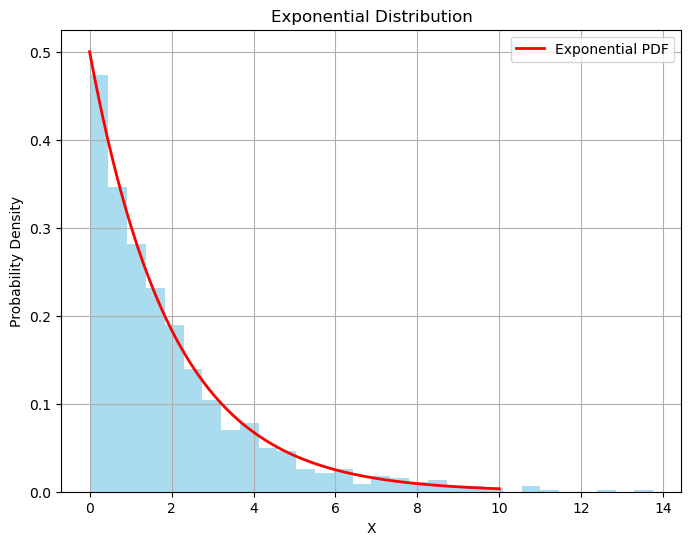

In [232]:
# Define parameters for the exponential distribution
lambda_param = 0.5  # lambda parameter for the exponential distribution

# Generate random samples from the exponential distribution
samples = np.random.exponential(scale=1/lambda_param, size=1000)

# Plot histogram of the generated samples
plt.figure(figsize=(8, 6))
plt.hist(samples, bins=30, density=True, alpha=0.7, color='skyblue')

# Plot the probability density function (PDF) of the exponential distribution
x = np.linspace(0, 10, 1000)
pdf = lambda_param * np.exp(-lambda_param * x)
plt.plot(x, pdf, 'r-', lw=2, label='Exponential PDF')

plt.title('Exponential Distribution')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()